### Importing the necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from math import sin, cos, pi, exp
from scipy.interpolate import interp1d

### Defining constants

In [2]:
# Universal Constants
PI = pi
GRAVITY = 9.8004                    #! On the surface of the earth, (in m/s2)
RE = 6400000                        #! Radius of the earth (in m)
GM = GRAVITY * pow(RE, 2)

# Used in trajectory equations
I_SP = 400                          #! Specific impulse of the rocket (in s)
ALTITUDES = [0, 50, 100, 200, 400]  #! Pre-defined altitudes (in km)

# Used in mass calculation
# SS_ENGINE is the RS-25
SS_ENGINE_THRUST        = 2.15e6    #! in N
SS_ENGINE_MASS          = 3500      #! in kg

### Rocket Specifications

In [3]:
THRUST_VECTOR = [                   #! (in mega N)
    10.2e6, 9.79e6, 10.1e6, 3.77e6, 3e3
]
ANGLE_VECTOR = [                    #! (in km)
    400, 327.1e3
]
CONE_HALF_ANGLE = 0.108             #! (in radians)
ROCKET_RADIUS = 3.98                #! (in m)
TOTAL_MASS = 958.8e3                #! (in kg)

### Trajectory Equations
The equations used to calculate the derivatives of the 5 variables: [r, r', $\theta$, $\theta$ ', m]<br />
A state vector model comprising of the above 5 parameters will be used. The end variables will be calculated via euler method, the quations for which are as follows:
<br/>

$
\frac{d}{dt}r = \dot{r}
$
<br/>
$
\frac{d}{dt}\dot{r} = -\frac{\mu}{r^{2}} + r\dot{\theta}^{2} + \frac{T(r) - D(r, \dot{r})}{m}cos(\alpha (r))
$
<br/>
$
\frac{d}{dt}\theta = \dot{\theta}
$
<br/>
$
\frac{d}{dt}\dot{\theta} = \frac{T(r) - D(r, \dot{r})}{r*m}sin(\alpha (r))
$
<br/>
$
\frac{d}{dt}m = \frac{-T(r)}{I_{sp}*g_{o}}
$

### Rocket
The class has the following variables:
- Private:
    - **__thrust_profile**: Linearly interpolated thrust at various altitudes
    - **__angle_profile**: Calculated angle of the rocket w.r.t. normal at various altitudes
    - **__altitude_profile**: Altitude of the rocket w.r.t. time
    - **__velocity_profile**: Radial velocity of the rocket w.r.t. time
    - **__acceleration_profile**: Radial acceleration of the rocket w.r.t. time
    - **__drag_profile**: Drag force acting on the rocket w.r.t. altitude
    - **__mass_profile**: Mass of the rocket w.r.t. time

- Public:
    - **thrust_vector**: The thrust force at 5 different altitudes
    - **angle_vector**: The altitudes at which gravity turn starts and ends
    - **cone_half_angle**: The half angle formed by the nose cone
    - **rocket_radius**: Radius of the rocket
    - **total_mass**: Initial Wet mass of the rocket
    - **max_altitude**: The maximum altitude reached by the rocket
    - **max_q_time**: THe time at which rocket achieves maximum dynamic pressure
    - **mass_propellant**: Propellant mass
    - **mass_engine**: Engine mass
    - **mass_structural**: Structural mass
    - **mass_payload**: Payload mass

In [4]:
class Rocket():
    def __init__(self, thrust_vector, angle_vector, cone_half_angle, rocket_radius, total_mass):
        # Pre-determined parameters
        self.thrust_vector = thrust_vector
        self.angle_vector = angle_vector
        self.cone_half_angle = cone_half_angle
        self.rocket_radius = rocket_radius
        self.total_mass = total_mass

        # Intermediate profile generation
        self.__thrust_profile = self.__calc_thrust_profile()
        self.__angle_profile = self.__calc_angle_profile()
        self.__altitude_profile = []
        self.__velocity_profile = []
        self.__acceleration_profile = []
        self.__drag_profile = []
        self.__mass_profile = []
        self.__time_profile = []
        self.__calc_profiles()

        # Final parameters
        self.max_altitude = (self.__altitude_profile[-1] - 6400e3) / 1000
        self.max_q_time = self.__calc_max_q_time()
        self.mass_propellant, self.mass_engine, self.mass_structural, self.mass_payload = self.__calc_masses()

    # Linear interpolation of thrust force
    def __calc_thrust_profile(self):
        interp_func = interp1d(ALTITUDES, self.thrust_vector)
        return interp_func(range(401))

    # Calculation of angle at any altitude
    def __calc_angle_profile(self):
        angle_profile = []
        alpha1, alpha2 = self.angle_vector
        i = 0
        while i < alpha1:
            angle_profile.append(0)
            i += 1000
        while i < alpha1+alpha2:
            angle_profile.append(PI/4 * (1 - cos(PI * (i-alpha1) / alpha2)))
            i += 1000
        while i <= 400e3:
            angle_profile.append(PI/2)
            i += 1000
        return angle_profile

    # Calculating rocket profiles
    def __calc_profiles(self):
        i = 0
        Z = [RE, 0.0, 0.0, 0.0, self.total_mass]
        while (Z[1] >= 0):
            Z_dash = self.__calc_derivatives(Z)
            self.__altitude_profile.append(Z[0])
            self.__velocity_profile.append(Z[1])
            self.__acceleration_profile.append(Z_dash[1])
            self.__mass_profile.append(Z[4])
            self.__time_profile.append(i)
            for j in range(5):
                Z[j] += Z_dash[j] * 0.01
            i += 1

    # Calculating point of max Q
    def __calc_max_q_time(self):
        return self.__drag_profile.index(max(self.__drag_profile))

    # Calculating masses
    def __calc_masses(self):
        mass_engine = (self.thrust_vector[0] / SS_ENGINE_THRUST) * SS_ENGINE_MASS
        mass_propellant = self.__mass_profile[0] - self.__mass_profile[-1]
        mass_structural = self.total_mass * 0.15
        mass_payload = self.total_mass - (mass_engine + mass_propellant + mass_structural)
        return mass_propellant, mass_engine, mass_structural, mass_payload

    # Helper functions
    def __get_thrust(self, r):
        alt = int(r/1000 - 6400)
        if (alt > 400):
            return 0
        return self.__thrust_profile[alt]
    
    def __get_angle(self, r):
        alt = int(r/1000 - 6400)
        if (alt > 400):
            return PI/2
        return self.__angle_profile[alt]

    def __get_density(self, r):
        alt = r/1000 - 6400
        return (1.2 * exp(-1 * alt / 10.4))

    def __get_drag(self, r, v):
        density = self.__get_density(r)
        coeff_of_drag = 2 * pow(sin(self.cone_half_angle), 2)
        rocket_area = PI * pow(self.rocket_radius, 2)
        return (0.5 * coeff_of_drag * rocket_area * density * pow(v, 2))

    def __calc_derivatives(self, Z):
        r, r_dash, theta, theta_dash, m = Z
        thrust = self.__get_thrust(r)
        drag = self.__get_drag(r, r_dash)
        angle = self.__get_angle(r)
        self.__drag_profile.append(drag)
        x1 = r_dash
        x2 = -(GM / pow(r, 2)) + (r * pow(theta_dash, 2)) + ((thrust - drag) * cos(angle) / m)
        x3 = theta_dash
        x4 = (thrust - drag) * sin(angle) / (r * m)
        x5 = -1 * thrust / (I_SP * GRAVITY)
        return np.array((x1, x2, x3, x4, x5))

    # Printing and plotting functions
    def print_details(self):
        print("Total Mass: {} kg".format(round(self.total_mass, 2)))
        print("    Propellant Mass: {} kg".format(round(self.mass_propellant, 2)))
        print("    Structural Mass: {} kg".format(round(self.mass_structural, 2)))
        print("    Engine Mass    : {} kg".format(round(self.mass_engine, 2)))
        print("    Payload Mass   : {} kg".format(round(self.mass_payload, 2)))

    def plot_thrust_profile(self):
        plt.figure(figsize=(12, 8))
        plt.grid()
        plt.plot(self.__thrust_profile)
        plt.scatter(ALTITUDES, self.thrust_vector, color='red')
        plt.title("Thrust Profile")
        plt.xlabel("Altitude (in km)")
        plt.ylabel("Thrust (in N)")
        plt.legend(['Linear Interpolation', 'Thrust Force'])
        plt.show()

    def plot_angle_profile(self):
        alpha1, alpha2 = self.angle_vector
        alpha1 = int(alpha1 / 1000)
        alpha2 = int(alpha2 / 1000)
        plt.figure(figsize=(12, 8))
        plt.grid()
        plt.plot(self.__angle_profile)
        plt.scatter([alpha1], [self.__angle_profile[alpha1]], color='red')
        plt.scatter([alpha1+alpha2], [self.__angle_profile[alpha1+alpha2]], color='green')
        plt.title("Angle Profile")
        plt.xlabel("Altitude (in km)")
        plt.ylabel("Angle (in radian)")
        plt.legend(['Angle Profile', 'Gravity turn starts', 'Gravity turn ends'])
        plt.show()

    def plot_altitude_profile(self):
        plt.figure(figsize=(12, 8))
        plt.grid()
        plt.plot([i/100 for i in self.__time_profile], [(i-6400e3)/1000 for i in self.__altitude_profile])
        plt.title("Altitude Profile")
        plt.xlabel("Time (in seconds)")
        plt.ylabel("Altitude (in kms)")
        plt.show()

    def plot_velocity_profile(self):
        plt.figure(figsize=(12, 8))
        plt.grid()
        plt.plot([i/100 for i in self.__time_profile], self.__velocity_profile)
        plt.title("Velocity Profile")
        plt.xlabel("Time (in seconds)")
        plt.ylabel("Velocity (in m/s)")
        plt.show()

    def plot_acceleration_profile(self):
        plt.figure(figsize=(12, 8))
        plt.grid()
        plt.plot([i/100 for i in self.__time_profile], self.__acceleration_profile)
        plt.title("Acceleration Profile")
        plt.xlabel("Time (in seconds)")
        plt.ylabel("Acceleration (in m/s^2)")
        plt.show()

    def plot_mass_profile(self):
        plt.figure(figsize=(12, 8))
        plt.grid()
        plt.plot([i/100 for i in self.__time_profile], self.__mass_profile)
        plt.title("Mass Profile")
        plt.xlabel("Time (in seconds)")
        plt.ylabel("Mass (in kg)")
        plt.show()
    
    def plot_drag_profile(self):
        plt.figure(figsize=(12, 8))
        plt.grid()
        plt.plot([(i-6400e3)/1000 for i in self.__altitude_profile], self.__drag_profile)
        plt.scatter([self.__altitude_profile[self.max_q_time]/1000 - 6400], [self.__drag_profile[self.max_q_time]], color='red')
        plt.title("Drag Profile")
        plt.xlabel("Altitude (in km)")
        plt.ylabel("Drag (in N)")
        plt.legend(['Drag Profile', 'Max Q point'])
        plt.show()

### Initialize
Generating a sample rocket

In [5]:
sample_rocket = Rocket(THRUST_VECTOR, ANGLE_VECTOR, CONE_HALF_ANGLE, ROCKET_RADIUS, TOTAL_MASS)

### Printing details

In [6]:
sample_rocket.print_details()

Total Mass: 958800.0 kg
    Propellant Mass: 743687.89 kg
    Structural Mass: 143820.0 kg
    Engine Mass    : 16604.65 kg
    Payload Mass   : 54687.46 kg


### Thrust force v/s Altitude

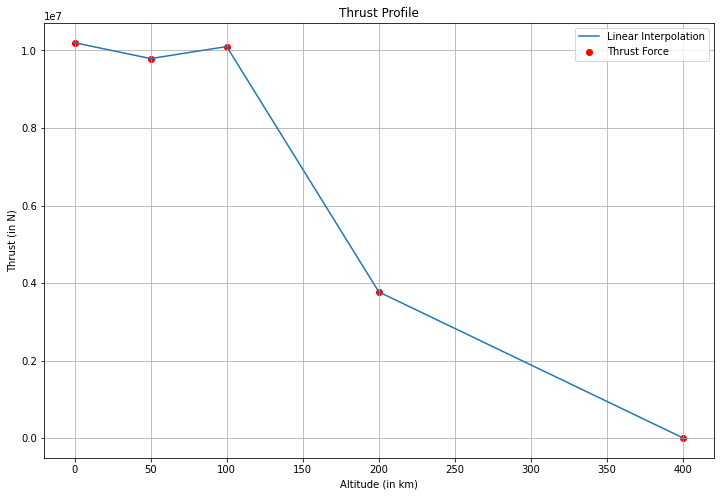

In [7]:
sample_rocket.plot_thrust_profile()

### Angle w.r.t. normal v/s Altitude

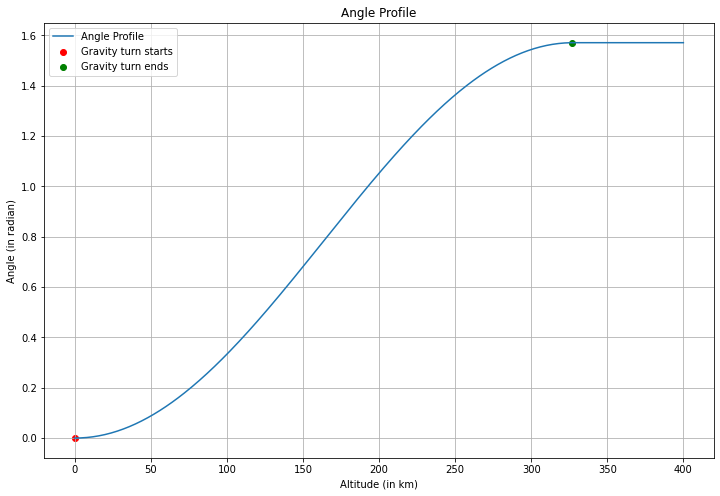

In [8]:
sample_rocket.plot_angle_profile()

### Altitude w.r.t. Time

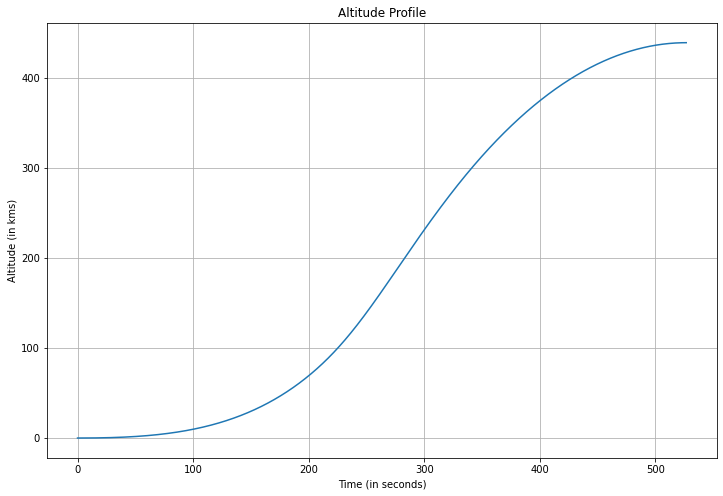

In [9]:
sample_rocket.plot_altitude_profile()

### Radial velocity w.r.t. Time

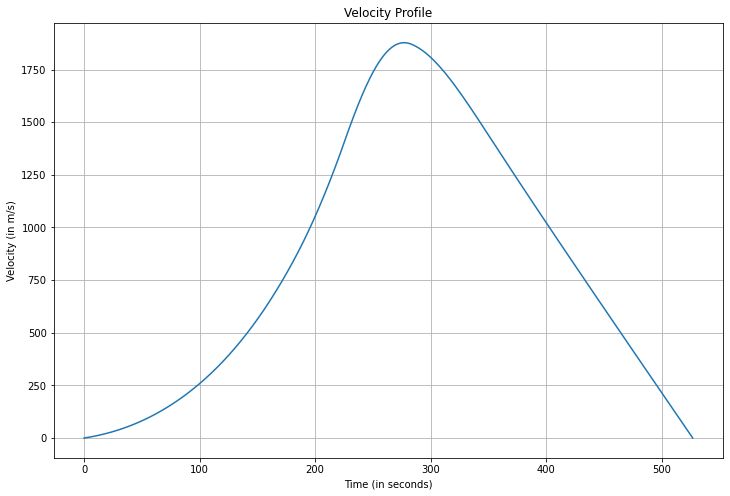

In [10]:
sample_rocket.plot_velocity_profile()

### Radial Acceleration w.r.t. Time

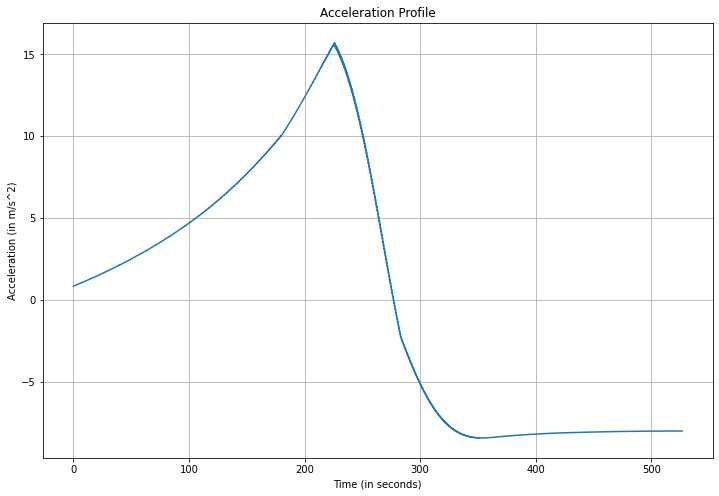

In [11]:
sample_rocket.plot_acceleration_profile()

### Drag force w.r.t. Altitude

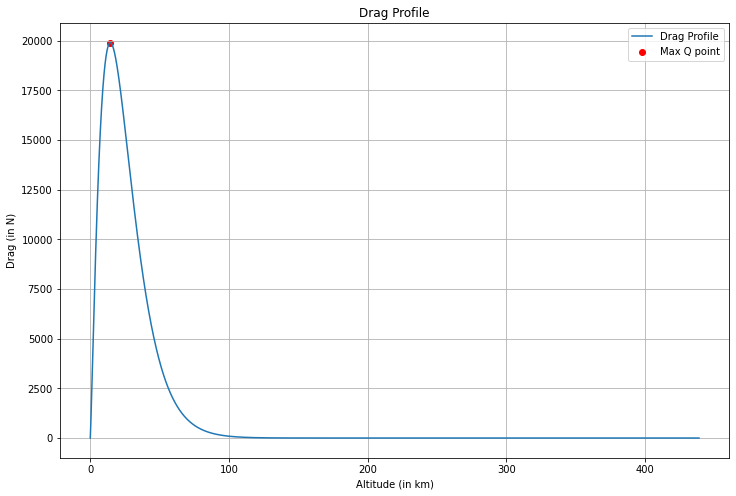

In [12]:
sample_rocket.plot_drag_profile()

### Mass of the rocket w.r.t. Time

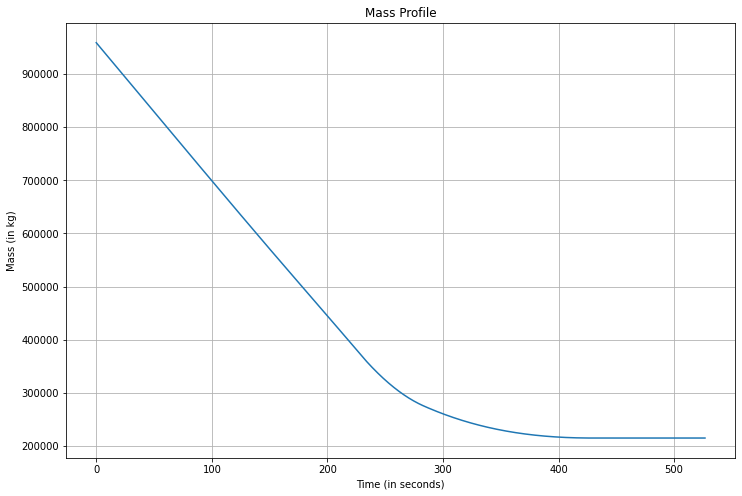

In [13]:
sample_rocket.plot_mass_profile()